In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


### load packages

In [3]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [5]:
import requests
import json
url = "https://raw.githubusercontent.com/duhaime/umap-zoo/03819ed0954b524919671a72f61a56032099ba11/data/json/bison.json"
animal = np.array(json.loads(requests.get(url).text)['3d'])
np.shape(animal)

(50000, 3)

(-1.0595327718040621,
 0.9895327718040622,
 -0.49177443340691684,
 0.6626744334069168)

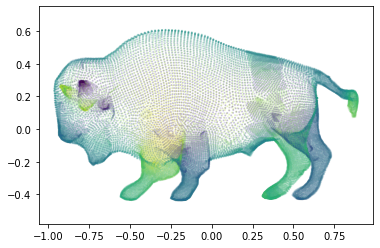

In [6]:
fig, ax = plt.subplots()
ax.scatter(animal[:,2], animal[:,1], s = 1, c = animal[:,0], alpha = 0.1)
ax.axis('equal')

In [7]:
X_train = animal
Y_train = animal[:, 2]
X_train_flat = X_train

### Create model and train

In [8]:
embedder = tfUMAP(n_neighbors = 150, direct_embedding=True, verbose=True)

In [9]:
z = embedder.fit_transform(X_train_flat)

Construct fuzzy simplicial set
Thu Jul  2 23:02:37 2020 Finding Nearest Neighbors
Thu Jul  2 23:02:37 2020 Building RP forest with 16 trees
Thu Jul  2 23:02:38 2020 parallel NN descent for 16 iterations
	 0  /  16
	 1  /  16
Thu Jul  2 23:03:04 2020 Finished Nearest Neighbor Search
Thu Jul  2 23:03:37 2020 Embedding with TensorFlow


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Thu Jul  2 23:05:16 2020 Finished embedding


### Plot model output

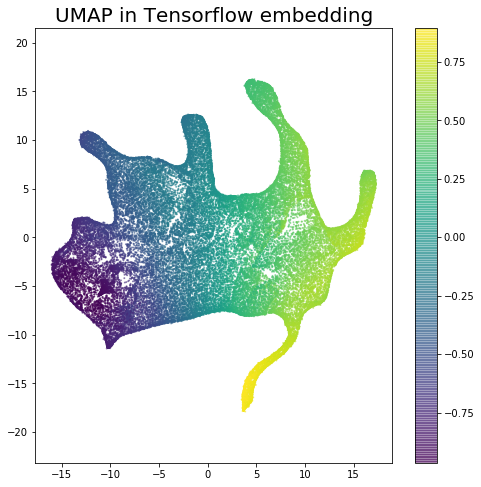

In [10]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train,
    cmap="viridis",
    s=1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### View loss

In [11]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

In [12]:
loss_df = retrieve_tensors(embedder.tensorboard_logdir)
loss_df[:3]

['umap_loss']
[]


,wall_time,step,val,group,variable
0,1.593756e+09,1,0.462964,train,umap_loss
1,1.593756e+09,2,0.442661,train,umap_loss
2,1.593756e+09,3,0.423373,train,umap_loss


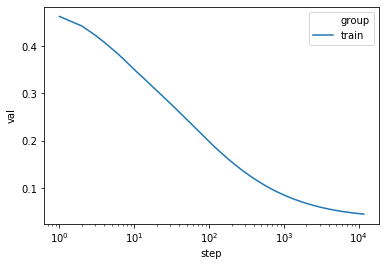

In [13]:
ax = sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='umap_loss'])
ax.set_xscale('log')

### Compare to direct embedding with base UMAP

In [14]:
from umap import UMAP

In [15]:
z_umap = UMAP(verbose=True, n_neighbors=150).fit_transform(X_train_flat)

UMAP(dens_frac=0.0, dens_lambda=0.0, n_neighbors=150, verbose=True)
Construct fuzzy simplicial set
Thu Jul  2 23:05:20 2020 Finding Nearest Neighbors
Thu Jul  2 23:05:20 2020 Building RP forest with 16 trees
Thu Jul  2 23:05:21 2020 parallel NN descent for 16 iterations
	 0  /  16
	 1  /  16
Thu Jul  2 23:05:39 2020 Finished Nearest Neighbor Search
Thu Jul  2 23:05:41 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Jul  2 23:06:35 2020 Finished embedding


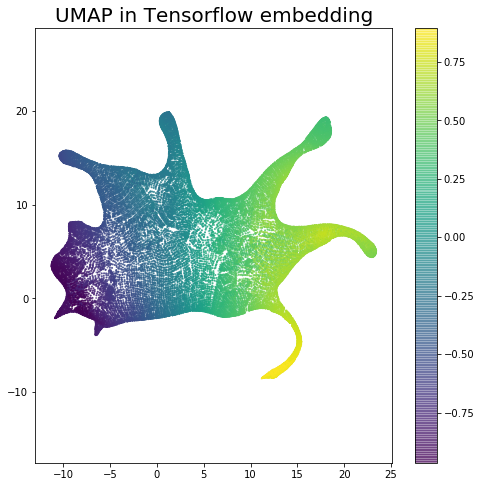

In [16]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z_umap[:, 0],
    z_umap[:, 1],
    c=Y_train,
    cmap="viridis",
    s=1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

In [17]:
### realign using procrustes 
from scipy.spatial import procrustes
z_align, z_umap_align, disparity = procrustes(z, z_umap)
print(disparity)

0.057563708744834144


Text(0.5, 1.0, 'UMAP with UMAP-learn')

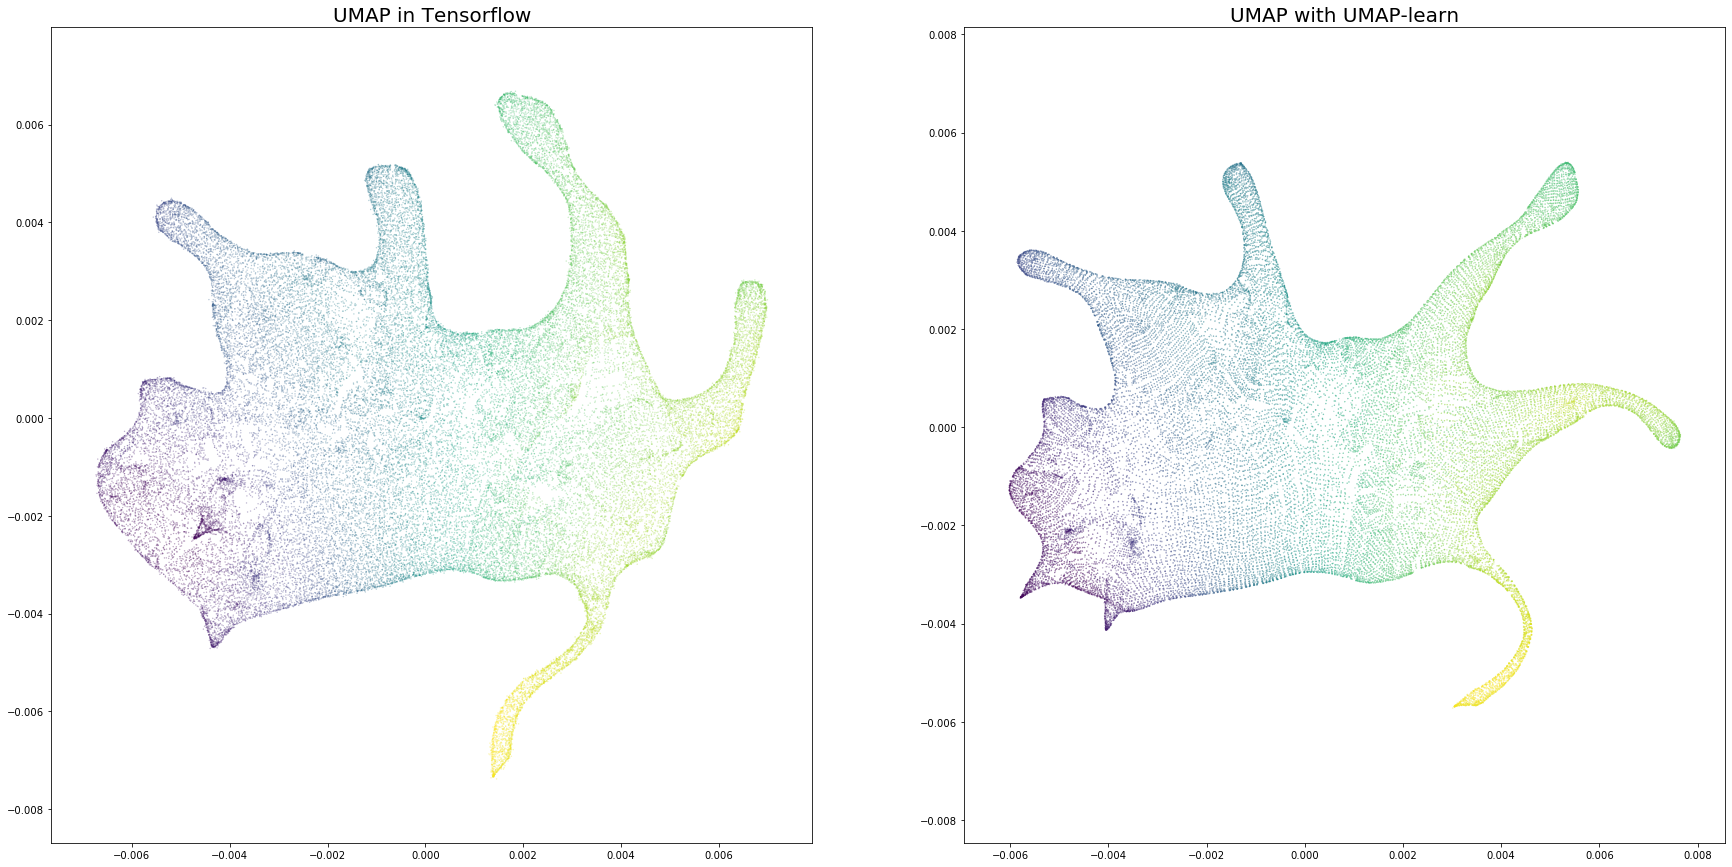

In [24]:
fig, axs = plt.subplots(ncols=2, figsize=(30, 15))
ax = axs[0]
sc = ax.scatter(
    z_align[:, 0],
    z_align[:, 1],
    c=Y_train,
    cmap="viridis",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow", fontsize=20)
#plt.colorbar(sc, ax=ax);

ax = axs[1]
sc = ax.scatter(
    z_umap_align[:, 0],
    z_umap_align[:, 1],
    c=Y_train,
    cmap="viridis",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP with UMAP-learn", fontsize=20)
#plt.colorbar(sc, ax=ax);